<a href="https://colab.research.google.com/github/moumahan1990/retail_timeseries_forecasting/blob/master/RNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.12.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 83.1MB 66kB/s 
     |████████████████████████████████| 3.1MB 42.2MB/s 
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc2


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

1.12.0


In [0]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
%matplotlib inline
import pandas as pd;
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,RNN, SimpleRNN 
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import LambdaCallback
from sklearn.preprocessing import MinMaxScaler

In [0]:
train = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/train.csv", 
                    parse_dates = True, low_memory = False, index_col = 'Date')
# additional store data
store = pd.read_csv("https://raw.githubusercontent.com/moumahan1990/retail_timeseries_forecasting/master/datasets/store.csv",low_memory = False)

In [0]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [0]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
# Creating new features from date 
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales']/train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [5]:
# Filtering out stores which are closed and has zero sales
train_data = train[train.Store == 1]
train_data = train_data[(train_data["Open"] != 0) & (train_data['Sales'] != 0)]
train_data=train_data.sort_index()
train_data=train_data.fillna(0)
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [0]:
train_data_X = train_data[['Month', 'Day', 'WeekOfYear','DayOfWeek' , 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'SalePerCustomer']]

In [0]:
train_data_y = train_data[['Sales']]

In [8]:
#Creating train test split
# X_train = train_data_X.head(730)
# X_test = train_data_X.tail(50)
# y_train = train_data_y.head(730)
# y_test = train_data_y.tail(50)

number_of_test_data = 50
number_of_holdout_data = 50
number_of_training_data = len(train_data) - number_of_holdout_data - number_of_test_data
print ("total, train, test, holdout:", len(train_data), number_of_training_data, number_of_test_data, number_of_holdout_data)

total, train, test, holdout: 781 681 50 50


In [9]:
datatrain = train_data[:number_of_training_data]
datatest = train_data[-(number_of_test_data+number_of_holdout_data):-number_of_holdout_data]
datahold = train_data[-number_of_holdout_data:]
datatrain.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1,2013,1,2,1,8.278443
2013-01-03,1,4,4327,578,1,0,0,1,2013,1,3,1,7.486159
2013-01-04,1,5,4486,619,1,0,0,1,2013,1,4,1,7.247173
2013-01-05,1,6,4997,635,1,0,0,1,2013,1,5,1,7.869291
2013-01-07,1,1,7176,785,1,1,0,1,2013,1,7,2,9.141401


In [0]:
#Preparing Train,Test,Validation data for TimeSeriesGenerator
in_seq1 = array(datatrain['Month'])
in_seq2 = array(datatrain['Day'])
in_seq3 = array(datatrain['WeekOfYear'])
in_seq4 = array(datatrain['DayOfWeek'])
in_seq5 = array(datatrain['Open'])
in_seq6 = array(datatrain['Promo'])
in_seq7 = array(datatrain['StateHoliday'])
in_seq8 = array(datatrain['SchoolHoliday'])
in_seq9 = array(datatrain['SalePerCustomer'])

out_seq_train = array(datatrain['Sales'])

In [0]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_train = out_seq_train.reshape((len(out_seq_train), 1))


In [12]:
datatrain_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_train))
datatrain_feed

array([[1, 2, 1, ..., 1, 8.278443113772456, 5530],
       [1, 3, 1, ..., 1, 7.486159169550173, 4327],
       [1, 4, 1, ..., 1, 7.247172859450727, 4486],
       ...,
       [3, 27, 13, ..., 0, 7.570888468809073, 4005],
       [3, 28, 13, ..., 0, 8.608264462809917, 5208],
       [3, 30, 14, ..., 1, 9.63271162123386, 6714]], dtype=object)

In [0]:
in_seq1 = array(datahold['Month'])
in_seq2 = array(datahold['Day'])
in_seq3 = array(datahold['WeekOfYear'])
in_seq4 = array(datahold['DayOfWeek'])
in_seq5 = array(datahold['Open'])
in_seq6 = array(datahold['Promo'])
in_seq7 = array(datahold['StateHoliday'])
in_seq8 = array(datahold['SchoolHoliday'])
in_seq9 = array(datahold['SalePerCustomer'])

out_seq_hold = array(datahold['Sales'])

In [14]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_hold = out_seq_hold.reshape((len(out_seq_hold), 1))
out_seq_hold.shape

(50, 1)

In [15]:
datathold_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_hold))
datathold_feed

array([[6, 3, 23, 3, 1, 1, '0', 0, 9.430194805194805, 5809],
       [6, 5, 23, 5, 1, 1, '0', 0, 8.84072249589491, 5384],
       [6, 6, 23, 6, 1, 0, '0', 0, 9.093478260869565, 4183],
       [6, 8, 24, 1, 1, 0, '0', 0, 8.109561752988048, 4071],
       [6, 9, 24, 2, 1, 0, '0', 0, 8.457731958762887, 4102],
       [6, 10, 24, 3, 1, 0, '0', 0, 7.927152317880795, 3591],
       [6, 11, 24, 4, 1, 0, '0', 0, 8.205882352941176, 3627],
       [6, 12, 24, 5, 1, 0, '0', 0, 8.755924170616113, 3695],
       [6, 13, 24, 6, 1, 0, '0', 0, 8.47808764940239, 4256],
       [6, 15, 25, 1, 1, 1, '0', 0, 9.416382252559726, 5518],
       [6, 16, 25, 2, 1, 1, '0', 0, 9.646123260437376, 4852],
       [6, 17, 25, 3, 1, 1, '0', 0, 8.403361344537815, 4000],
       [6, 18, 25, 4, 1, 1, '0', 0, 9.32730923694779, 4645],
       [6, 19, 25, 5, 1, 1, '0', 0, 8.628336755646817, 4202],
       [6, 20, 25, 6, 1, 0, '0', 0, 8.293522267206479, 4097],
       [6, 22, 26, 1, 1, 0, '0', 0, 7.865030674846626, 3846],
       [6, 23, 2

In [0]:
in_seq1 = array(datatest['Month'])
in_seq2 = array(datatest['Day'])
in_seq3 = array(datatest['WeekOfYear'])
in_seq4 = array(datatest['DayOfWeek'])
in_seq5 = array(datatest['Open'])
in_seq6 = array(datatest['Promo'])
in_seq7 = array(datatest['StateHoliday'])
in_seq8 = array(datatest['SchoolHoliday'])
in_seq9 = array(datatest['SalePerCustomer'])

out_seq_test = array(datatest['Sales'])

In [17]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
out_seq_test = out_seq_hold.reshape((len(out_seq_test), 1))
out_seq_test.shape

(50, 1)

In [18]:
datatest_feed = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, out_seq_test))
datatest_feed.shape

(50, 10)

In [0]:
# TimeSeries Generator for Train data 
n_features = datatrain_feed.shape[1]
n_input = 30
generator_train = TimeseriesGenerator(datatrain_feed, out_seq_train, length=n_input, batch_size=1)


In [20]:
for i in range(len(generator_train)):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

Streaming output truncated to the last 5000 lines.
  [8 21 34 4 1 1 '0' 1 8.940082644628099 4327]
  [8 22 34 5 1 1 '0' 1 8.613882863340564 3971]
  [8 23 34 6 1 0 '0' 1 7.637526652452026 3582]
  [8 25 35 1 1 0 '0' 1 7.603563474387528 3414]
  [8 26 35 2 1 0 '0' 1 7.3826086956521735 3396]
  [8 27 35 3 1 0 '0' 1 7.477434679334917 3148]
  [8 28 35 4 1 0 '0' 1 8.394004282655246 3920]
  [8 29 35 5 1 0 '0' 1 8.813211845102506 3869]
  [8 30 35 6 1 0 '0' 1 7.903474903474904 4094]
  [9 1 36 1 1 1 '0' 1 9.739750445632799 5464]
  [9 2 36 2 1 1 '0' 1 8.879432624113475 5008]
  [9 3 36 3 1 1 '0' 1 9.235621521335807 4978]
  [9 4 36 4 1 1 '0' 1 8.57199211045365 4346]
  [9 5 36 5 1 1 '0' 1 8.50994575045208 4706]
  [9 6 36 6 1 0 '0' 0 7.687378640776699 3959]
  [9 8 37 1 1 0 '0' 0 6.935849056603773 3676]
  [9 9 37 2 1 0 '0' 0 7.69248291571754 3377]
  [9 10 37 3 1 0 '0' 0 7.310267857142857 3275]
  [9 11 37 4 1 0 '0' 0 7.762013729977117 3392]]] => [[3906]]
[[[8 9 32 6 1 0 '0' 1 8.281746031746032 4174]
  [8 1

In [0]:
# TimeSeries Generator for Val data
generator_hold = TimeseriesGenerator(datathold_feed, out_seq_hold, length=n_input, batch_size=1)

In [22]:
for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    print('%s => %s' % (x, y))

[[[6 3 23 3 1 1 '0' 0 9.430194805194805 5809]
  [6 5 23 5 1 1 '0' 0 8.84072249589491 5384]
  [6 6 23 6 1 0 '0' 0 9.093478260869565 4183]
  [6 8 24 1 1 0 '0' 0 8.109561752988048 4071]
  [6 9 24 2 1 0 '0' 0 8.457731958762887 4102]
  [6 10 24 3 1 0 '0' 0 7.927152317880795 3591]
  [6 11 24 4 1 0 '0' 0 8.205882352941176 3627]
  [6 12 24 5 1 0 '0' 0 8.755924170616113 3695]
  [6 13 24 6 1 0 '0' 0 8.47808764940239 4256]
  [6 15 25 1 1 1 '0' 0 9.416382252559726 5518]
  [6 16 25 2 1 1 '0' 0 9.646123260437376 4852]
  [6 17 25 3 1 1 '0' 0 8.403361344537815 4000]
  [6 18 25 4 1 1 '0' 0 9.32730923694779 4645]
  [6 19 25 5 1 1 '0' 0 8.628336755646817 4202]
  [6 20 25 6 1 0 '0' 0 8.293522267206479 4097]
  [6 22 26 1 1 0 '0' 0 7.865030674846626 3846]
  [6 23 26 2 1 0 '0' 0 8.416107382550335 3762]
  [6 24 26 3 1 0 '0' 0 8.082125603864734 3346]
  [6 25 26 4 1 0 '0' 0 8.159353348729793 3533]
  [6 26 26 5 1 0 '0' 0 7.897619047619048 3317]
  [6 27 26 6 1 0 '0' 0 8.680345572354211 4019]
  [6 29 27 1 1 1 '0' 

In [0]:
# TimeSeries Generator for Test data
generator_test = TimeseriesGenerator(datatest_feed, out_seq_test, length=n_input, batch_size=1)

In [25]:
for i in range(len(generator_test)):
    x, y = generator_test[i]
    print('%s => %s' % (x, y))

[[[3 31 14 2 1 1 '0' 1 10.536502546689304 5809]
  [4 1 14 3 1 1 '0' 1 9.640735502121641 5384]
  [4 2 14 4 1 1 '0' 1 9.105263157894736 4183]
  [4 4 14 6 1 0 '0' 1 8.428391959798995 4071]
  [4 7 15 2 1 0 '0' 1 7.500900900900901 4102]
  [4 8 15 3 1 0 '0' 1 8.388 3591]
  [4 9 15 4 1 0 '0' 1 8.06279069767442 3627]
  [4 10 15 5 1 0 '0' 1 8.292056074766355 3695]
  [4 11 15 6 1 0 '0' 0 7.948571428571428 4256]
  [4 13 16 1 1 1 '0' 0 9.367595818815332 5518]
  [4 14 16 2 1 1 '0' 0 8.687850467289719 4852]
  [4 15 16 3 1 1 '0' 0 8.203592814371257 4000]
  [4 16 16 4 1 1 '0' 0 8.575 4645]
  [4 17 16 5 1 1 '0' 0 9.232876712328768 4202]
  [4 18 16 6 1 0 '0' 0 8.444852941176471 4097]
  [4 20 17 1 1 0 '0' 0 7.754166666666666 3846]
  [4 21 17 2 1 0 '0' 0 7.300480769230769 3762]
  [4 22 17 3 1 0 '0' 0 8.075425790754258 3346]
  [4 23 17 4 1 0 '0' 0 7.220657276995305 3533]
  [4 24 17 5 1 0 '0' 0 7.3180778032036615 3317]
  [4 25 17 6 1 0 '0' 0 8.04096834264432 4019]
  [4 27 18 1 1 1 '0' 0 9.712543554006968 51

In [26]:
print("timesteps, features:", n_input, n_features)

timesteps, features: 30 10


In [27]:
#RNN  Model
model = Sequential()

model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features), return_sequences = False))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

from tensorflow.keras.losses import MAPE
rmsprop = RMSprop(lr=0.0001)
model.compile(optimizer=rmsprop, loss=MAPE)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                210       
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [28]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='max', min_delta=3,verbose=1)

# score = model.fit_generator(generator_train, epochs=100, verbose=2, validation_data=generator_test, callbacks=[es])
score = model.fit_generator(generator_train, epochs=100, verbose=2, validation_data=generator_test)

Epoch 1/100
 - 3s - loss: 60.9972 - val_loss: 8.8282
Epoch 2/100
 - 3s - loss: 12.2788 - val_loss: 8.8325
Epoch 3/100
 - 3s - loss: 12.1965 - val_loss: 9.1733
Epoch 4/100
 - 2s - loss: 12.1514 - val_loss: 8.9843
Epoch 5/100
 - 2s - loss: 12.0059 - val_loss: 8.7771
Epoch 6/100
 - 3s - loss: 12.0700 - val_loss: 8.9808
Epoch 7/100
 - 3s - loss: 11.9262 - val_loss: 9.1013
Epoch 8/100
 - 3s - loss: 11.7944 - val_loss: 8.7198
Epoch 9/100
 - 2s - loss: 11.9487 - val_loss: 8.8205
Epoch 10/100
 - 2s - loss: 11.8616 - val_loss: 8.9903
Epoch 11/100
 - 2s - loss: 11.8666 - val_loss: 8.8548
Epoch 12/100
 - 2s - loss: 11.9062 - val_loss: 8.8995
Epoch 13/100
 - 2s - loss: 11.8285 - val_loss: 8.7854
Epoch 14/100
 - 2s - loss: 11.8977 - val_loss: 8.7306
Epoch 15/100
 - 2s - loss: 11.6893 - val_loss: 8.7267
Epoch 16/100
 - 3s - loss: 11.7862 - val_loss: 9.0614
Epoch 17/100
 - 2s - loss: 11.7954 - val_loss: 8.7679
Epoch 18/100
 - 2s - loss: 11.7602 - val_loss: 8.7466
Epoch 19/100
 - 2s - loss: 11.7184 - 

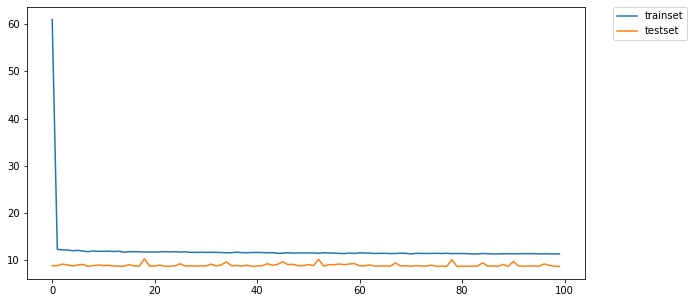

In [29]:
losses = score.history['loss']
val_losses = score.history['val_loss']
plt.figure(figsize=(10,5))
plt.plot(losses, label="trainset")
plt.plot(val_losses, label="testset")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [0]:
yhat = model.predict(generator_hold, verbose=2)

In [0]:
yhat.shape

(49, 1)

In [0]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generator_hold)):
    x, y = generator_hold[i]
    x_input = array(x).reshape((1, n_input, n_features))
    yhat = model.predict(x_input, verbose=2)
    df_result = df_result.append({'Actual': y[0][0], 'Prediction': yhat[0][0]}, ignore_index=True)

In [32]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

rmse_rf = sqrt(mean_squared_error(df_result.Actual, df_result.Prediction))
MAPE= np.mean(np.abs((df_result.Actual - df_result.Prediction) / df_result.Actual)) * 100
print("MAPE: ",MAPE)
print("MAE: ", mean_absolute_error(df_result.Actual, df_result.Prediction))
print("RMSE: ",rmse_rf)

MAPE:  8.619971164915434
MAE:  410.1069091796875
RMSE:  618.2745210523053


In [0]:
def MASE(training_series, testing_series, prediction_series):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d
def smape(actual, predicted):
    # return 100/len(test) * np.sum(2 * np.abs(pred - test) / (np.abs(test) + np.abs(pred)))
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted))))

In [39]:
print("MASE",MASE(datatrain.Sales,df_result.Actual,df_result.Prediction))
print("SMAPE",smape(df_result.Actual,df_result.Prediction))

MASE 0.7035311139084929
SMAPE 0.09175182334672258
